# Project-4 Advanced Lane Line Detection using Traditional Computer Vision

### Part-1: Finding Camera Calibration Matrix and Distortion Coefficients

In [1]:
import numpy as np
import pandas as pd
import pickle
import cv2
import os
import os.path as path
import moviepy
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import collections
from moviepy.editor import VideoFileClip
%matplotlib inline

In [2]:
cd C:/Users/ravit/Desktop/SDC_Nano_Degree/Project-4/CarND-Advanced-Lane-Lines-master

C:\Users\ravit\Desktop\SDC_Nano_Degree\Project-4\CarND-Advanced-Lane-Lines-master


In [3]:
image_dir = 'camera_cal'
images = glob.glob(path.join(image_dir,'calibration*.jpg'))
imagepoints = []
objectpoints = []

for image in images:
    img = cv2.imread(image)
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)                             # Convert to Grayscale
    is_corner, corners = cv2.findChessboardCorners(gray, (9,6), None)       # Find Corners
    if is_corner:                                                           
        imgpoints = corners
        objp = np.zeros((6*9,3), np.float32)
        objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)
        imagepoints.append(imgpoints)   # Append all Image points from corners
        objectpoints.append(objp)       # Append all Object Points from real-world points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objectpoints, imagepoints, gray.shape[::-1], None, None)      
with open('calibration_vales.p','wb') as f:
    if ret:
        pickle.dump((mtx, dist),f)
def undistort(raw_img):
    with open('calibration_vales.p','rb') as f:
        mtx,dist = pickle.load(f)
    undist = cv2.undistort(raw_img, mtx, dist, None, mtx)
    return undist

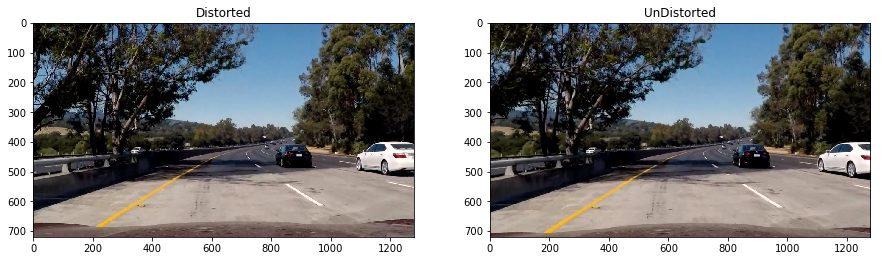

In [21]:
raw_img =  cv2.imread('test_images/test5.jpg')
undist = undistort(raw_img)

fig = plt.figure(figsize = (15,15))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.set_title('Distorted')
ax2.set_title('UnDistorted')
ax1.imshow(cv2.cvtColor(raw_img,code = cv2.COLOR_BGR2RGB))
ax2.imshow(cv2.cvtColor(undist,code = cv2.COLOR_BGR2RGB))

# mpimg.imsave('Raw_Image.jpg',cv2.cvtColor(raw_img,code = cv2.COLOR_BGR2RGB))
# mpimg.imsave('Undistorted_Image.jpg',cv2.cvtColor(undist,code = cv2.COLOR_BGR2RGB))

### Part-2 Image Binarization

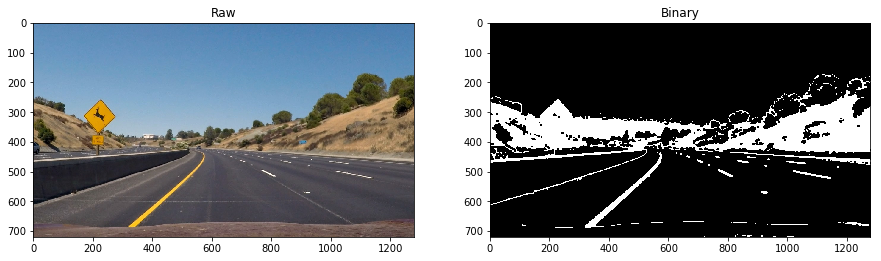

In [7]:
def binarize(img, print_images=False):

    # Yellow Mask  in HSV color space
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    yellow = cv2.inRange(hsv,np.array([0, 90, 90]),np.array([100, 255, 255]))

    # white mask using equalized grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    eq_global = cv2.equalizeHist(gray)
    white = np.zeros_like(eq_global)
    white[(eq_global>=249) & (eq_global<=255)] = 1
    
    # Sobel Mask
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=9)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=9)
    magsobel = np.sqrt(sobelx ** 2 + sobely ** 2)
    magsobel = np.uint8(magsobel / np.max(magsobel) * 255)
    grad = np.arctan2(sobely,sobelx)
    grads = np.zeros_like(grad)
    grads[(grad>=0.7)&(grads<=1.1)]
    sobel = np.zeros_like(magsobel)
    sobel[(magsobel>=70)&(magsobel<=255)] = 1
    
    
    out = np.zeros_like(yellow)
    out = np.logical_and(magsobel, grads)
    out = np.logical_or(yellow, white)
    out = np.logical_or(out, sobel)

    # Morphology for continuity
    final = cv2.morphologyEx(np.uint8(out), cv2.MORPH_CLOSE, np.ones((5, 5), np.uint8))
    return final

# Plotting Binarized images
raw_img = cv2.imread('test_images/test2.jpg')
binar = binarize(raw_img)
fig = plt.figure(figsize = (15,15))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.set_title('Raw')
ax2.set_title('Binary')
ax1.imshow(cv2.cvtColor(raw_img,cv2.COLOR_BGR2RGB))
ax2.imshow(binar,cmap = 'gray')

# mpimg.imsave('binarize.jpg',binar,cmap='gray')
# mpimg.imsave('raw.jpg',cv2.cvtColor(raw_img,cv2.COLOR_BGR2RGB),cmap = 'gray')

In [8]:
# Perspective Transform

def perpective(img):
    h, w = img.shape[:2]

    src = np.float32([[w, h-15], [0, h-15], [530, 460], [730, 460]])
    dst = np.float32([[w, h], [0, h], [0, 0], [w, 0]])
    
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)

    warped = cv2.warpPerspective(img, M, (w, h), flags=cv2.INTER_LINEAR)

    return warped, M, Minv

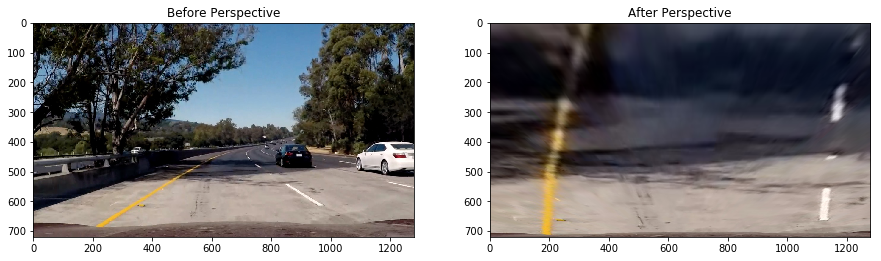

In [9]:
# Test Perspective on test images
test_img = "test_images/test5.jpg"
img = cv2.imread(test_img)
img_undist = undistort(img)
img_binary = binarize(img_undist)
persp, M, Minv = perpective(img)

f, ax = plt.subplots(1, 2,figsize=(15,10))
ax[0].set_title('Before Perspective')
ax[0].imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
ax[1].set_title('After Perspective')
ax[1].imshow(cv2.cvtColor(persp,cv2.COLOR_BGR2RGB))

# mpimg.imsave('before_persp.jpg',cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
# mpimg.imsave('after_persp.jpg',cv2.cvtColor(persp,cv2.COLOR_BGR2RGB))

### Lane Detection

In [10]:
class Line:
    def __init__(self, run_len=15): # Running length takes the recent n iterations.

        # Check for Detection. Set initially to none detected
        self.detected = False

        # meter and pixel fits from previous iterations. Initially set to None.
        self.last_fit_pixel = None
        self.last_fit_meter = None

        # Polynomial coefficients of the last N iterations
        self.run_fit_pixel = collections.deque(maxlen=run_len)
        self.run_fit_meter = collections.deque(maxlen=2 * run_len)

        self.radius_of_curvature = None # Recording Radius at each moment

        # Pixel Data-line of x & y
        self.pxl_x = None
        self.pxl_y = None

    def update(self, new_fit_pixel, new_fit_meter, detected, clear_run=False):

        self.detected = detected

        if clear_run:
            self.run_fit_pixel = []
            self.run_fit_meter = []

        self.last_fit_pixel = new_fit_pixel
        self.last_fit_meter = new_fit_meter

        self.run_fit_pixel.append(self.last_fit_pixel)
        self.run_fit_meter.append(self.last_fit_meter)

    def draw(self, mask, line_width=50, color=(255, 0, 0)):

        h, w, c = mask.shape # height, width and color

        y_coor = np.linspace(0, h - 1, h)
        coeffs = self.fit_mean

        line_center = coeffs[0] * y_coor ** 2 + coeffs[1] * y_coor + coeffs[2]
        line_left = line_center - line_width // 2
        line_right = line_center + line_width // 2

        pts_left = np.array(list(zip(line_left, y_coor)))
        pts_right = np.array(np.flipud(list(zip(line_right, y_coor))))
        pts = np.vstack([pts_left, pts_right])   # Stacking values for polyfit
        
        line = cv2.fillPoly(mask, [np.int_(pts)], color)

        return line

    @property
    def fit_mean(self):
        return np.mean(self.run_fit_pixel, axis=0) # Mean of running pixels

    @property
    def curv_pxl(self):
        y_eval = 0
        coeffs = self.fit_mean
        return ((1 + (2 * coeffs[0] * y_eval + coeffs[1]) ** 2) ** 1.5) / np.absolute(2 * coeffs[0]) # Radius of curvature for pixels

    @property
    def curv_mtr(self):
        y_eval = 0
        coeffs = np.mean(self.run_fit_meter, axis=0)
        return ((1 + (2 * coeffs[0] * y_eval + coeffs[1]) ** 2) ** 1.5) / np.absolute(2 * coeffs[0]) # Radius of curvature for meter values

In [11]:
y_perpxl = 30 / 720   # meters per pixel in y dimension
x_perpxl = 3.5 / 700  # meters per pixel in x dimension
time_window = 15  

def sliding_windows(binary_warped,line_left,line_right,number_windows = 9,print_image = False): 
    
    height, width = binary_warped.shape
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:-20,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = histogram.shape[0]//2
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = number_windows
    # Set height of windows
    window_height = np.int_(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    line_left.pxl_x = nonzerox[left_lane_inds]
    line_left.pxl_y = nonzeroy[left_lane_inds] 
    line_right.pxl_x = nonzerox[right_lane_inds]
    line_right.pxl_y = nonzeroy[right_lane_inds]        
    
    detected = True
    if not list(line_left.pxl_x) or not list(line_left.pxl_y):
        left_fit_pixel = line_left.last_fit_pixel
        left_fit_meter = line_left.last_fit_meter
        detected = False
    else:
        left_fit_pixel = np.polyfit(line_left.pxl_y, line_left.pxl_x, 2)
        left_fit_meter = np.polyfit(line_left.pxl_y * y_perpxl, line_left.pxl_x * x_perpxl, 2)

    if not list(line_right.pxl_x) or not list(line_right.pxl_y):
        right_fit_pixel = line_right.last_fit_pixel
        right_fit_meter = line_right.last_fit_meter
        detected = False
    else:
        right_fit_pixel = np.polyfit(line_right.pxl_y, line_right.pxl_x, 2)
        right_fit_meter = np.polyfit(line_right.pxl_y * y_perpxl, line_right.pxl_x * x_perpxl, 2)

    line_left.update(left_fit_pixel, left_fit_meter, detected=detected)
    line_right.update(right_fit_pixel, right_fit_meter, detected=detected)

    # Generate x and y values for plotting
    y_val = np.linspace(0, height - 1, height)
    left_fitt = left_fit_pixel[0] * y_val ** 2 + left_fit_pixel[1] * y_val + left_fit_pixel[2]
    right_fitt = right_fit_pixel[0] * y_val ** 2 + right_fit_pixel[1] * y_val + right_fit_pixel[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    if print_image:
        f, ax = plt.subplots(1, 2, figsize=(15,6))
        ax[0].imshow(binary_warped, cmap='gray')
        ax[1].imshow(out_img)
        ax[1].plot(left_fitt, y_val, color='blue')
        ax[1].plot(right_fitt, y_val, color='red')
        ax[1].set_xlim(0, 1280)
        ax[1].set_ylim(720, 0)
        # mpimg.imsave('detected_lanes.jpg',binary_warped,cmap='gray')
        # mpimg.imsave('sliding.jpg',out_img)

    return line_left, line_right, out_img

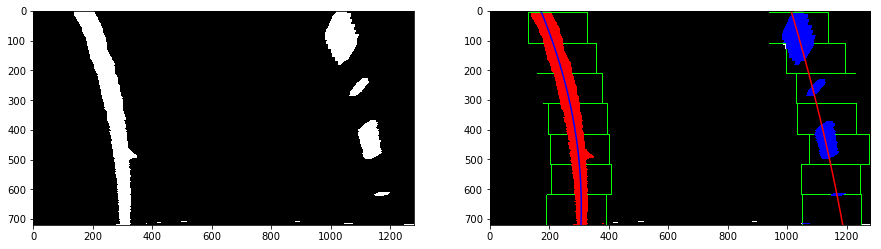

In [12]:
line_left, line_right = Line(run_len=10), Line(run_len=10)
img = cv2.imread("test_images/test2.jpg")
img_undistorted = undistort(img)
img_binary = binarize(img_undistorted)
img_persp, M, Minv = perpective(img_binary)
line_left, line_right, img_out = sliding_windows(img_persp, line_left, line_right, number_windows=7, print_image=True)

In [13]:
y_perpxl = 30 / 720   # meters per pixel in y dimension
x_perpxl = 3.5 / 700  # meters per pixel in x dimension

def approx_by_previous_fits(binary_warped, line_left, line_right, print_image=False):

    height, width = binary_warped.shape

    left_fit_pixel = line_left.last_fit_pixel
    right_fit_pixel = line_right.last_fit_pixel

    nonzero = binary_warped.nonzero()
    nonzero_y = np.array(nonzero[0])
    nonzero_x = np.array(nonzero[1])
    margin = 100
    left_lane_inds = (
    (nonzero_x > (left_fit_pixel[0] * (nonzero_y ** 2) + left_fit_pixel[1] * nonzero_y + left_fit_pixel[2] - margin)) & (
    nonzero_x < (left_fit_pixel[0] * (nonzero_y ** 2) + left_fit_pixel[1] * nonzero_y + left_fit_pixel[2] + margin)))
    right_lane_inds = (
    (nonzero_x > (right_fit_pixel[0] * (nonzero_y ** 2) + right_fit_pixel[1] * nonzero_y + right_fit_pixel[2] - margin)) & (
    nonzero_x < (right_fit_pixel[0] * (nonzero_y ** 2) + right_fit_pixel[1] * nonzero_y + right_fit_pixel[2] + margin)))

    # Extract left and right line pixel positions
    line_left.pxl_x, line_left.pxl_y = nonzero_x[left_lane_inds], nonzero_y[left_lane_inds]
    line_right.pxl_x, line_right.pxl_y = nonzero_x[right_lane_inds], nonzero_y[right_lane_inds]

    detected = True
    if not list(line_left.pxl_x) or not list(line_left.pxl_y):
        left_fit_pixel = line_left.last_fit_pixel
        left_fit_meter = line_left.last_fit_meter
        detected = False
    else:
        left_fit_pixel = np.polyfit(line_left.pxl_y, line_left.pxl_x, 2)
        left_fit_meter = np.polyfit(line_left.pxl_y * y_perpxl, line_left.pxl_x * x_perpxl, 2)

    if not list(line_right.pxl_x) or not list(line_right.pxl_y):
        right_fit_pixel = line_right.last_fit_pixel
        right_fit_meter = line_right.last_fit_meter
        detected = False
    else:
        right_fit_pixel = np.polyfit(line_right.pxl_y, line_right.pxl_x, 2)
        right_fit_meter = np.polyfit(line_right.pxl_y * y_perpxl, line_right.pxl_x * x_perpxl, 2)

    line_left.update(left_fit_pixel, left_fit_meter, detected=detected)
    line_right.update(right_fit_pixel, right_fit_meter, detected=detected)

    y_val = np.linspace(0, height - 1, height)
    left_fitx = left_fit_pixel[0] * y_val ** 2 + left_fit_pixel[1] * y_val + left_fit_pixel[2]
    right_fitx = right_fit_pixel[0] * y_val ** 2 + right_fit_pixel[1] * y_val + right_fit_pixel[2]

    # Image to show the Sliding window
    img_fit = np.dstack((binary_warped, binary_warped, binary_warped)) * 255
    window_img = np.zeros_like(img_fit)

    # Different Color in left and right lines
    img_fit[nonzero_y[left_lane_inds], nonzero_x[left_lane_inds]] = [255, 0, 0]
    img_fit[nonzero_y[right_lane_inds], nonzero_x[right_lane_inds]] = [0, 0, 255]

    # Polygon to show search window area
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx - margin, y_val]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx + margin, y_val])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx - margin, y_val]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx + margin, y_val])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw Poly for Final Result on window
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0, 255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0, 255, 0))
    result = cv2.addWeighted(img_fit, 1, window_img, 0.4, 0)

    if print_image:
        plt.imshow(result)
        plt.hold()
        plt.plot(left_fitx, ploty)
        plt.plot(right_fitx, ploty)
        plt.xlim(0, 1280)
        plt.ylim(720, 0)

    return line_left, line_right, img_fit

In [14]:
def blend_with_road(img_undistorted, Minv, line_left, line_right):

    height, width = img_undistorted.shape[:2]

    left_fit = line_left.fit_mean
    right_fit = line_right.fit_mean
    
    # x and y values for plots
    y_val = np.linspace(0, height - 1, height)
    left_fitt = left_fit[0] * y_val ** 2 + left_fit[1] * y_val + left_fit[2]
    right_fitt = right_fit[0] * y_val ** 2 + right_fit[1] * y_val + right_fit[2]

    # Lane drawn as green space
    warp_road = np.zeros_like(img_undistorted, dtype=np.uint8)
    pts_left = np.array([np.transpose(np.vstack([left_fitt, y_val]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitt, y_val])))])
    pts = np.hstack((pts_left, pts_right))
    cv2.fillPoly(warp_road, np.int_([pts]), (0, 255, 0))
    road_unwarped = cv2.warpPerspective(warp_road, Minv, (width, height))  # Warp back after drawing lines

    blend_road = cv2.addWeighted(img_undistorted, 1., road_unwarped, 0.4, 0)

    line_warp = np.zeros_like(img_undistorted)
    line_warp = line_left.draw(line_warp, color=(255, 0, 0))
    line_warp = line_right.draw(line_warp, color=(255, 0, 0))
    line_dewarped = cv2.warpPerspective(line_warp, Minv, (width, height))

    lines_mask = blend_road.copy()
    idx = np.any([line_dewarped != 0][0], axis=2)
    lines_mask[idx] = line_dewarped[idx]

    blend_road = cv2.addWeighted(src1=lines_mask, alpha=0.8, src2=blend_road, beta=0.5, gamma=0.)

    return blend_road

In [15]:
def print_final(blend_road, img_binary, img_persp, img_fit, line_left, line_right, offset_m):

    h, w = blend_road.shape[:2]

    thumb_ratio = 0.2
    thumb_h, thumb_w = int(thumb_ratio * h), int(thumb_ratio * w)

    off_x, off_y = 15, 15

    # Gray Rectangle added
    mask = blend_road.copy()
    mask = cv2.rectangle(mask, pt1=(0, 0), pt2=(500, thumb_h+2*off_y), color=(0, 0, 0), thickness=cv2.FILLED)
    blend_road = cv2.addWeighted(src1=mask, alpha=0.2, src2=blend_road, beta=0.8, gamma=0)

    # Curvature and offset text
    mean_curv = np.mean([line_left.curv_mtr, line_right.curv_mtr])
    font = cv2.FONT_HERSHEY_PLAIN
    cv2.putText(blend_road, 'Radius of curvature: {:.2f}m'.format(mean_curv), (30, 50), font, 1.6, (255, 255, 255), 2, cv2.LINE_AA)
    cv2.putText(blend_road, 'Offset from center: {:.2f}m'.format(offset_m), (30, 140), font, 1.6, (255, 255, 255), 2, cv2.LINE_AA)

    return blend_road

In [16]:
def compute_offset(line_left, line_right, fr_w):
    
    if line_left.detected and line_right.detected:
        line_left_bottom = np.mean(line_left.pxl_x[line_left.pxl_y > 0.95 * line_left.pxl_y.max()])
        line_right_bottom = np.mean(line_right.pxl_x[line_right.pxl_y > 0.95 * line_right.pxl_y.max()])
        lane_width = line_right_bottom - line_left_bottom
        midpoint = fr_w / 2
        offset_pxl = abs((line_left_bottom + lane_width / 2) - midpoint)
        offset_m = x_perpxl * offset_pxl
    else:
        offset_m = -1

    return offset_m

In [17]:
def process_total(img, keep_state=True):

    global line_left, line_right, pr_fr

    # undistort
    img_undistorted = undistort(img)

    # binarize
    img_binary = binarize(img_undistorted)

    # perspective
    img_persp, M, Minv = perpective(img_binary)

    # fit polynomial
    if pr_fr > 0 and keep_state and line_left.detected and line_right.detected:
        line_left, line_right, img_fit = approx_by_previous_fits(img_persp, line_left, line_right)
    else:
        line_left, line_right, img_fit = sliding_windows(img_persp, line_left, line_right, number_windows=11)

    # compute offset
    offset_m = compute_offset(line_left, line_right, fr_w=img.shape[1])

    # draw the surface
    blend_road = blend_with_road(img_undistorted, Minv, line_left, line_right)

    # Final output
    blend_output = print_final(blend_road, img_binary, img_persp, img_fit, line_left, line_right, offset_m)

    pr_fr += 1

    return blend_output

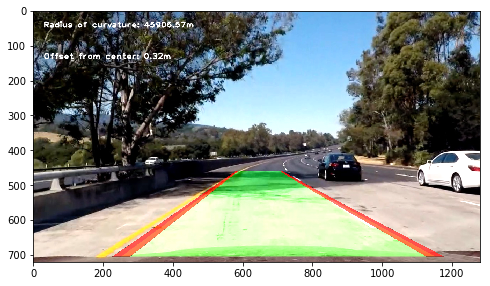

In [18]:
pr_fr = 0
frame = mpimg.imread("test_images/test5.jpg")
blend = process_total(frame, keep_state=False)
plt.figure(figsize=(8,8))
plt.grid('off')
plt.imshow(blend)

In [19]:
images = glob.glob(path.join("test_images", '*.jpg'))
itr =  0
for image in images:
    img = mpimg.imread(image)
    final = process_total(img, keep_state=False)
    itr += 1
    # mpimg.imsave("output_{}".format(itr) + '.jpg', final)

In [22]:
line_left, line_right = Line(run_len=10), Line(run_len=10)
pr_fr = 0
clip = VideoFileClip('project_video.mp4').fl_image(process_total)
clip.write_videofile('project_video_out.mp4', audio=False)

[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [08:40<00:00,  2.78it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 

